example script used for processing RCEMIP data and producing vertical domain averages
beware - not elegant, done variable by variable!

In [6]:
def vertinterpolate(var,lev, method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)

    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower.
    Based an a similar script by Aiko Voigt."""

    #import xarray as xr
    import numpy as np
    from scipy import interpolate

    # target vertical levels -> as input!
    zlev1 = np.array([0.1,0.3,0.5,0.75]) 
    zlev2 = np.arange(1, 24.1, 0.5)
    
    zlev_int = np.concatenate((zlev1,zlev2))

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind="linear", fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])

    return var_int

In [13]:
import numpy as np
# target vertical levels onto which regridded the standardized RCEMIP output
zlev1 = np.array([0.1,0.3,0.5,0.75]) 
zlev2 = np.arange(1, 24.1, 0.5)
 
zlev_int = np.concatenate((zlev1,zlev2))

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import ticker
import copy
import xarray as xr
import glob 

plt.rcParams.update({'font.size': 16}) #all to 18 if not specified other

#path to original, standardized RCEMIP data 
#The standardized RCEMIP output is hosted by the German Climate Computing Center (DKRZ) and is 
#publicly available at http://hdl.handle.net/21.14101/d4beee8e-6996-453e-bbd1-ff53b6874c0e. 
path = '/path-to-your-RCEMIP-data-folder/'

#separate file, vert coord in meters
models_z = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam']
vertdim_z  = ['altitude','z','z','z','lev','z']

#1 file, vert coord in meters
models_z1f=['MPAS','UCLA-CRM']
vertdim_z1f = ['height','zt']

##################

#separate file, 1d height in a separate file as zg_avg (meters, not constant in time)
model_lev_zvar = ['CAM5_GCM','CAM6_GCM','CNRM-CM6-1','GEOS_GCM'] 
vertdim_lev_zvar = ['zg_avg','zg_avg','zg_avg','zg_avg']#,

models = models_z+models_z1f+ model_lev_zvar

vertdim = vertdim_z+vertdim_z1f+vertdim_lev_zvar

#separate files, 1d height in a separate file as zg_avg (meters, constant in time)
models_lev_zconst = ['ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']
vertdim_lev_zconst = ['height_avg','height_avg','z_avg','z_avg','rho_height_levels','z']

models = models_z+models_z1f+ model_lev_zvar+models_lev_zconst

vertdim = vertdim_z+vertdim_z1f+vertdim_lev_zvar+vertdim_lev_zconst

#1 file, 1d height in a separate file as zg_avg (meters, constant in time)

ssts = ['295','300','305']
col = ['k','orange','crimson']

Here an example script that plots the standardized RCEMIP data and regrids them onto the chosen 0.5 km vertical grid (zlev_int). Finally, we save these processed quantities in a new ncfile if write=1.

Added only examples for two quantities, CRH and cloud ice (in kg/kg, different from ice water content).
Other quantities (cloud fraction, temperature, density) were computed using the same procedure)

MESONH 0
295
300
305
NICAM 1
295
300
305
SAM_CRM 2
295
300
305
SAM_GCRM 3
295
300
305
SCALE 4
295
300
305
dam 5
295
300
305
MPAS 6
295
300
305
UCLA-CRM 7
295
300
305
CAM5_GCM 8
295
300
305
CAM6_GCM 9
295
300
305
CNRM-CM6-1 10
295
300
305
GEOS_GCM 11
295
300
305
ICON_LEM_CRM 12
295
300
305
ICON_NWP_CRM 13
295
300
305
SP-CAM 14
295
300
305
SPX-CAM 15
295
300
305
UKMO-GA7.1 16
295
300
305
CM1 17
295
300
305


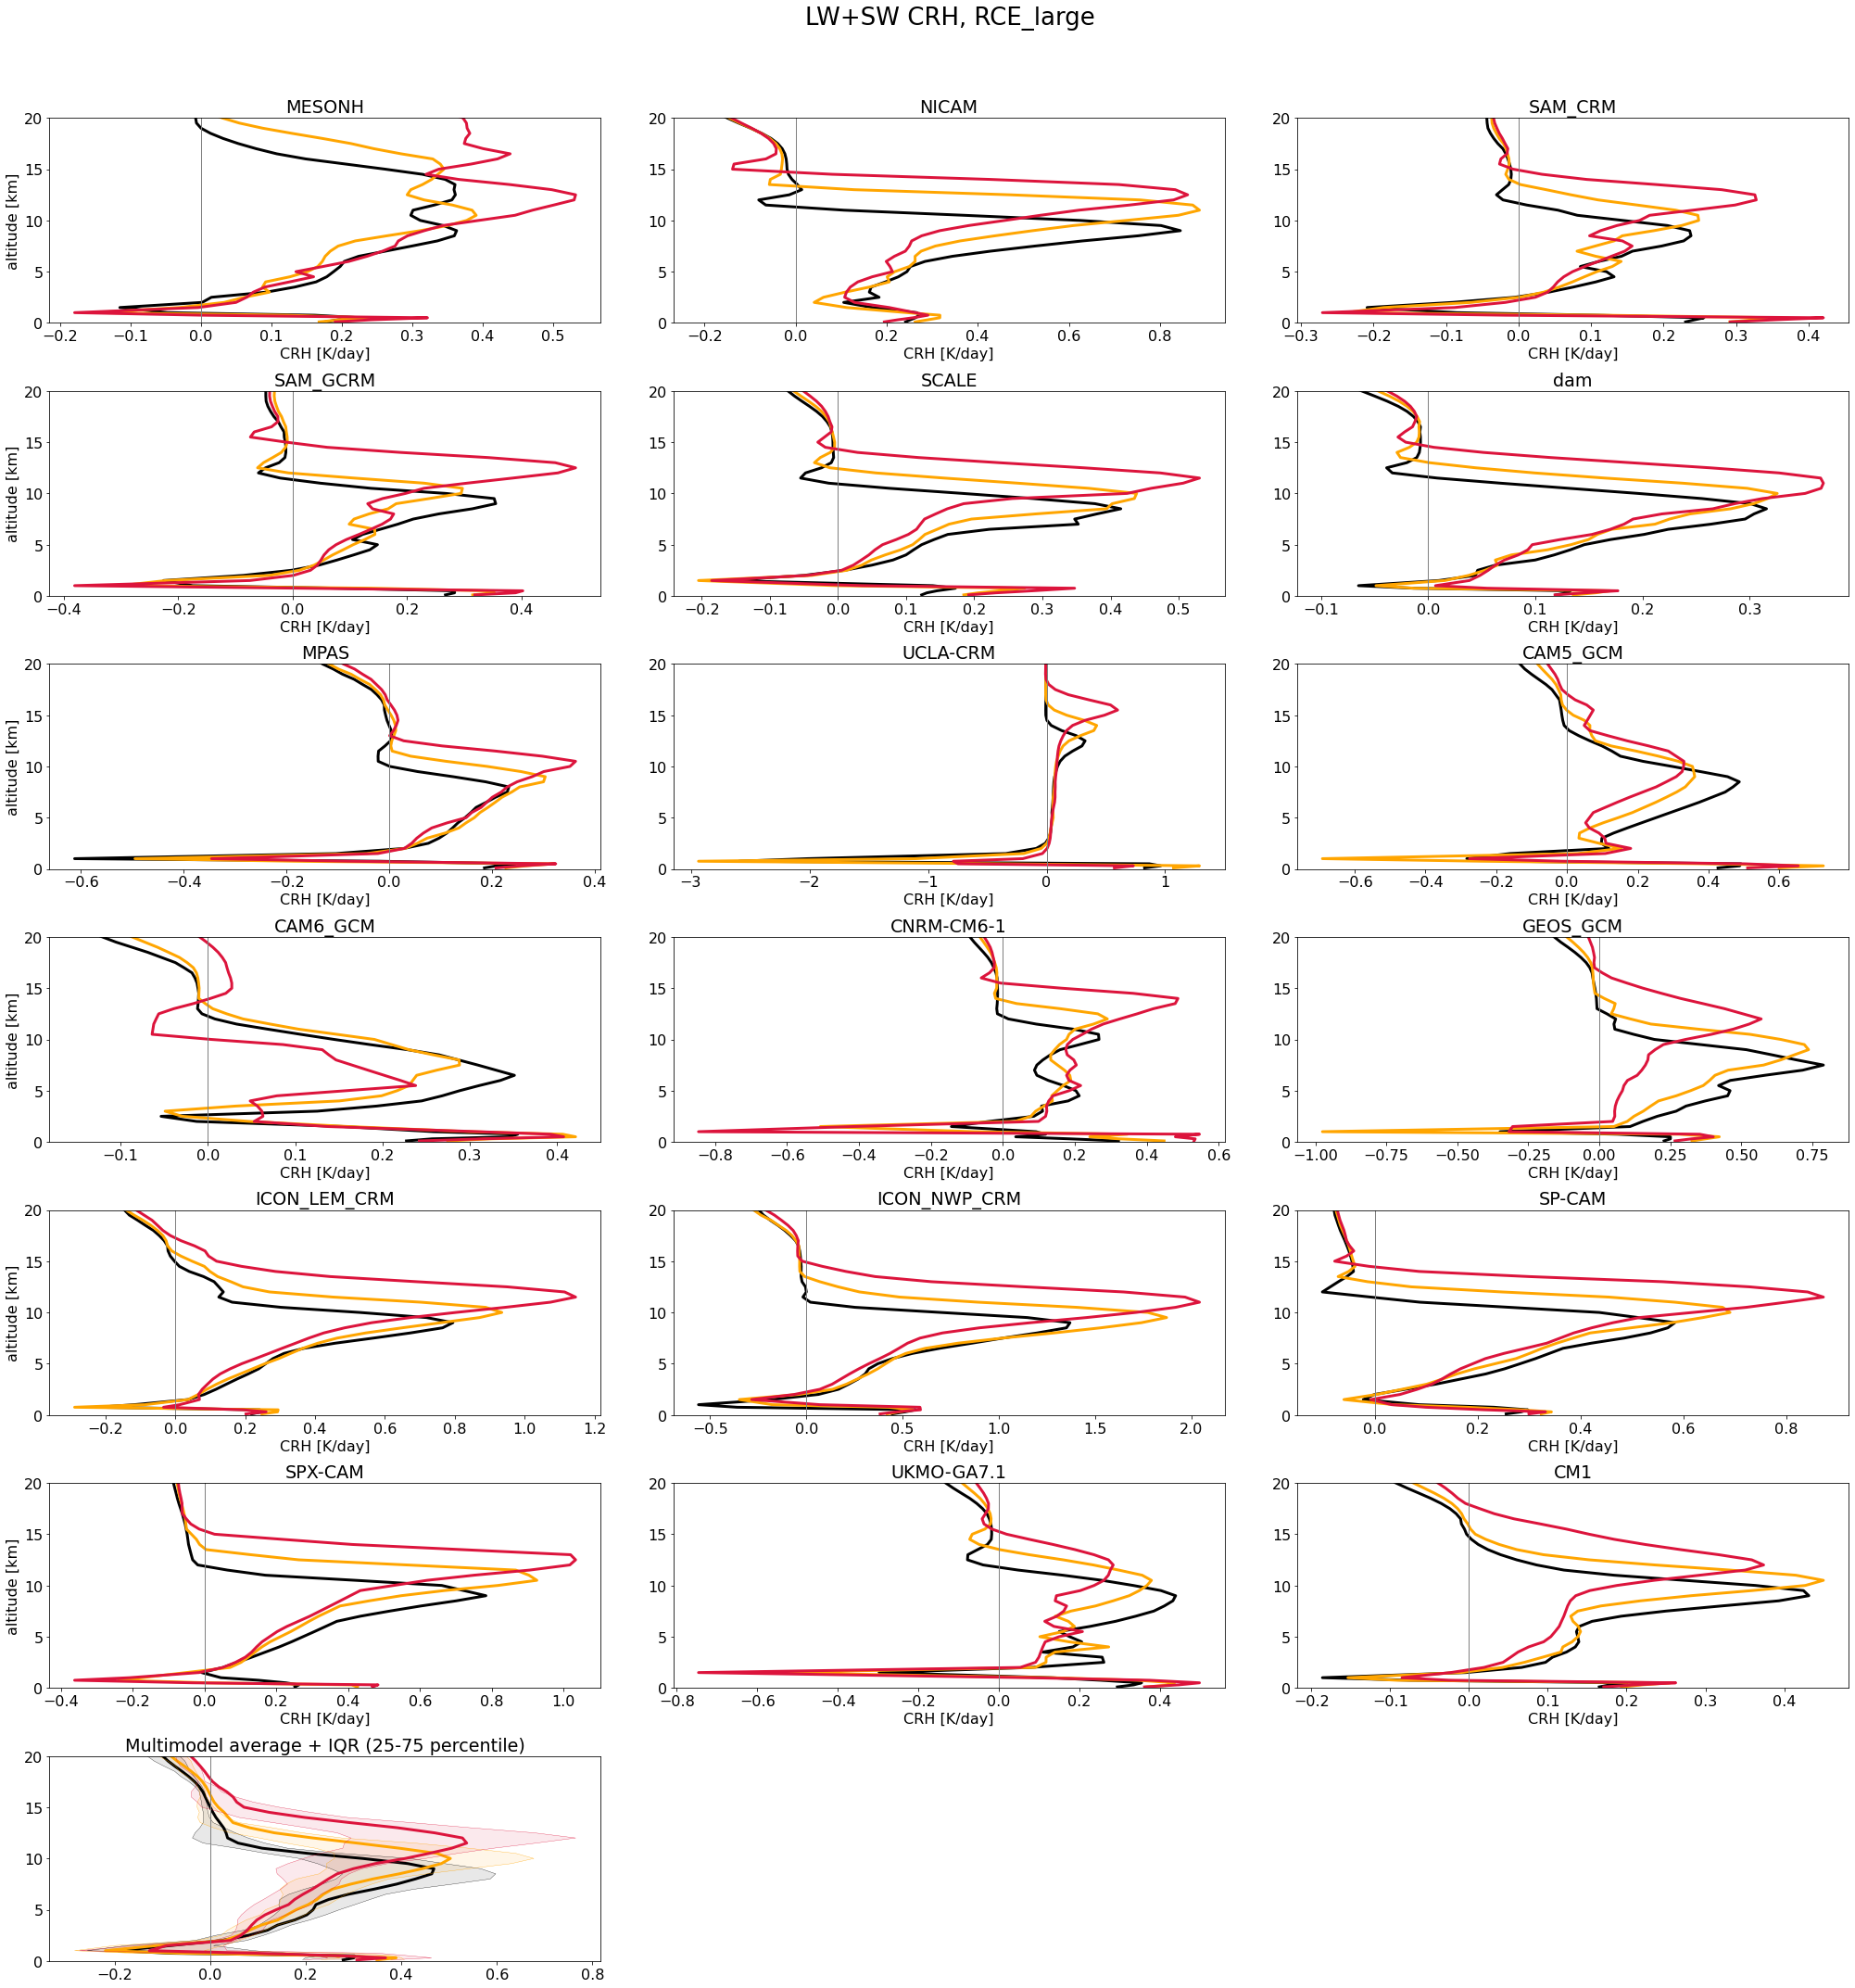

In [14]:
#CRH - both SW and LW here
fig = plt.figure()
fig.set_size_inches(36,42,forward=True)
gs = gridspec.GridSpec(15,30,height_ratios=[1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1],width_ratios=30*[1])


y0 = [0,0,0,2,2,2,4,4,4,6,6,6,8,8,8,10,10,10,12,12,12,14,14,14]
x0 = [0,10,20]*7


dataint={}
for m,model in enumerate(models):
    ax = fig.add_subplot(gs[y0[m],x0[m]:x0[m]+9])
    print(model,m)
    dataint[model]={}

    for s,sst in enumerate(ssts):
        print(sst)
        dataint[model][sst]={}

        ds = xr.merge([xr.open_dataset(v) for v in glob.glob(path+model+'/RCE_large'+sst+'/1D/'+model+'_RCE_large'+sst+'_1D*nc')],compat='override')

        #acre 0 stuff--------------
        if (model=='ICON_LEM_CRM') | (model=='ICON_NWP_CRM'):
            acre0 = ds['tntrs_avg'].squeeze().values - ds['tntrscs_avg'].squeeze().values + ds['tntrl_avg'].squeeze().values - ds['tntrlcs_avg'].squeeze().values
        else:
            acre0 = ds['tntrs_avg']- ds['tntrscs_avg'] + ds['tntrl_avg']-ds['tntrlcs_avg']
        #acre 0 end-----------------------------
        if model=='MPAS':
            acre = 86400*((acre0[-600:].mean(axis=1)).squeeze()).values
        else:
            if (model=='ICON_LEM_CRM') | (model=='ICON_NWP_CRM'):
                acre = 86400*((np.nanmean(acre0[-600:],axis=0)).squeeze())
            else:
                acre = 86400*((acre0[-600:].mean(axis=0)).squeeze()).values
        #acre end----------------------------------
        if m<8: #all models with vert coordinate in meters
            zlev = ds[vertdim[m]].values/1e3 #in km
        if (m>7) & (m<12): #all models with vert coordinate as a separate file, variable in time
            zlev=((ds[vertdim[m]][-600:].mean(axis=0,skipna=True)).squeeze()).values/1e3
        if m>11: #all models with vert coordinate as a separate file, constant time
            zlev=((ds[vertdim[m]]).squeeze()).values/1e3

        if (model=='SP-CAM')|(model=='SPX-CAM'):
            acre = acre[~np.isnan(acre)]
            zlev = zlev[~np.isnan(zlev)]
            
        #here, vertical regridding: maybe on 0.5 km grid between 0 and 24 km
        acre_interp = vertinterpolate(acre,zlev,method='scipy')
        
        #now, make a dictionary
        dataint[model][sst]=acre_interp 
            
        plt.plot(acre_interp, zlev_int,color=col[s],linewidth=3,linestyle='-',label=model+' '+sst) 
        plt.axvline(x = 0, color = 'gray',linewidth=1) 
        plt.axvline(x = 0, color = 'gray',linewidth=1)
        #plt.xlim(-0.6,2.5)
        plt.ylim(0,20)
                    
        plt.xlabel('CRH [K/day]')
        if np.mod(m,3)==0:
            plt.ylabel('altitude [km]')
        plt.title(model)
        
    if m==len(models)-1:
        ax = fig.add_subplot(gs[y0[m+1],x0[m+1]:x0[m+1]+9])
        meansst = np.zeros((len(ssts),len(zlev_int)))
        plotsst = np.zeros((len(zlev_int)))
        for s,sst in enumerate(ssts):
            cumsst=[]
            for model in dataint:
                dsst = dataint[model][sst]
                cumsst.append(dsst)
            cumsst=np.array(cumsst)
            meansst[s] = np.nanmean(cumsst,axis=0)
            plotsst    = np.nanmean(cumsst,axis=0)
            plot_1quartile    = np.nanpercentile(cumsst,25,axis=0)
            plot_3quartile   = np.nanpercentile(cumsst,75,axis=0)
            plt.plot(plotsst, zlev_int,color=col[s],linewidth=3,linestyle='-')#,label='multimodel average at')
            plt.plot(plot_1quartile, zlev_int,color=col[s],linewidth=0.3,linestyle='-')
            plt.plot(plot_3quartile, zlev_int,color=col[s],linewidth=0.3,linestyle='-')
            plt.fill_betweenx(zlev_int,plot_3quartile, plot_1quartile,facecolor=col[s],alpha=0.09,
            label='25 to 75 percentile range')

            plt.axvline(x = 0, color = 'gray',linewidth=1) 
            #plt.xlim(-0.6,2.5)
            plt.ylim(0,20) 
        plt.title('Multimodel average + IQR (25-75 percentile)')

plt.suptitle('LW+SW CRH, RCE_large',size=26,y=0.92)
#plt.savefig('path-to-file/CRH_RCE_large_analysis_0to20km_w_meanIQR_nolim.png',dpi=200,bbox_inches='tight')

write=0
if (write == 1):
    ##############WRITE IN A NC FILE##################################################

    ############################################################################
    from netCDF4 import Dataset as NetCDFFile
    import netCDF4

    savepath = '../data/RCEMIP_processed/'

    ncfile = NetCDFFile(savepath+'RCElarge_crh_from_1D_files_z24_testprocess.nc', 'w',  format='NETCDF4_CLASSIC')

    alt = ncfile.createDimension('alt', len(zlev_int) )
    model= ncfile.createDimension('model', len(models) )
    sst = ncfile.createDimension('sst', 3 )
    nchar = ncfile.createDimension('nchar',len(models))
    nchar2 = ncfile.createDimension('nchar2',12) #12 is the lenght of the longest model name

    #Create variables for the dimensions (so that we can have values there)
    alt= ncfile.createVariable('alt', np.float32, ('alt',))
    sst= ncfile.createVariable('sst', np.float32, ('sst',))
    
    # Create the actual 2-d variable
    cli_avg  = ncfile.createVariable('hr_acre', np.dtype('float32').char, ('model','sst','alt'))
    #cli_avg  = ncfile.createVariable('clear_sky_radiative_heating', np.dtype('float32').char, ('model','sst','alt'))    
    modelnames= ncfile.createVariable('names_of_models', 'S1',('nchar','nchar2'))
    
    str_out = netCDF4.stringtochar(np.array(models,'S'))
    
    # Variable Attributes  
    cli_avg.units   = 'K/day'
    
    #assign values
    alt[:]       = zlev_int
    sst[:]       = ssts
    model        = models #np.enumerate(models)
    modelnames[:]=str_out
    for m,model in enumerate(models):
        for s,sst in enumerate(ssts):
            cli_avg[m,s,:] =  dataint[model][sst]


    ncfile.close()

MESONH 0
NICAM 1
SAM_CRM 2
SAM_GCRM 3
SCALE 4
dam 5
MPAS 6
UCLA-CRM 7
CAM5_GCM 8
CAM6_GCM 9
CNRM-CM6-1 10
GEOS_GCM 11
ICON_LEM_CRM 12
ICON_NWP_CRM 13
SP-CAM 14
SPX-CAM 15
UKMO-GA7.1 16
CM1 17


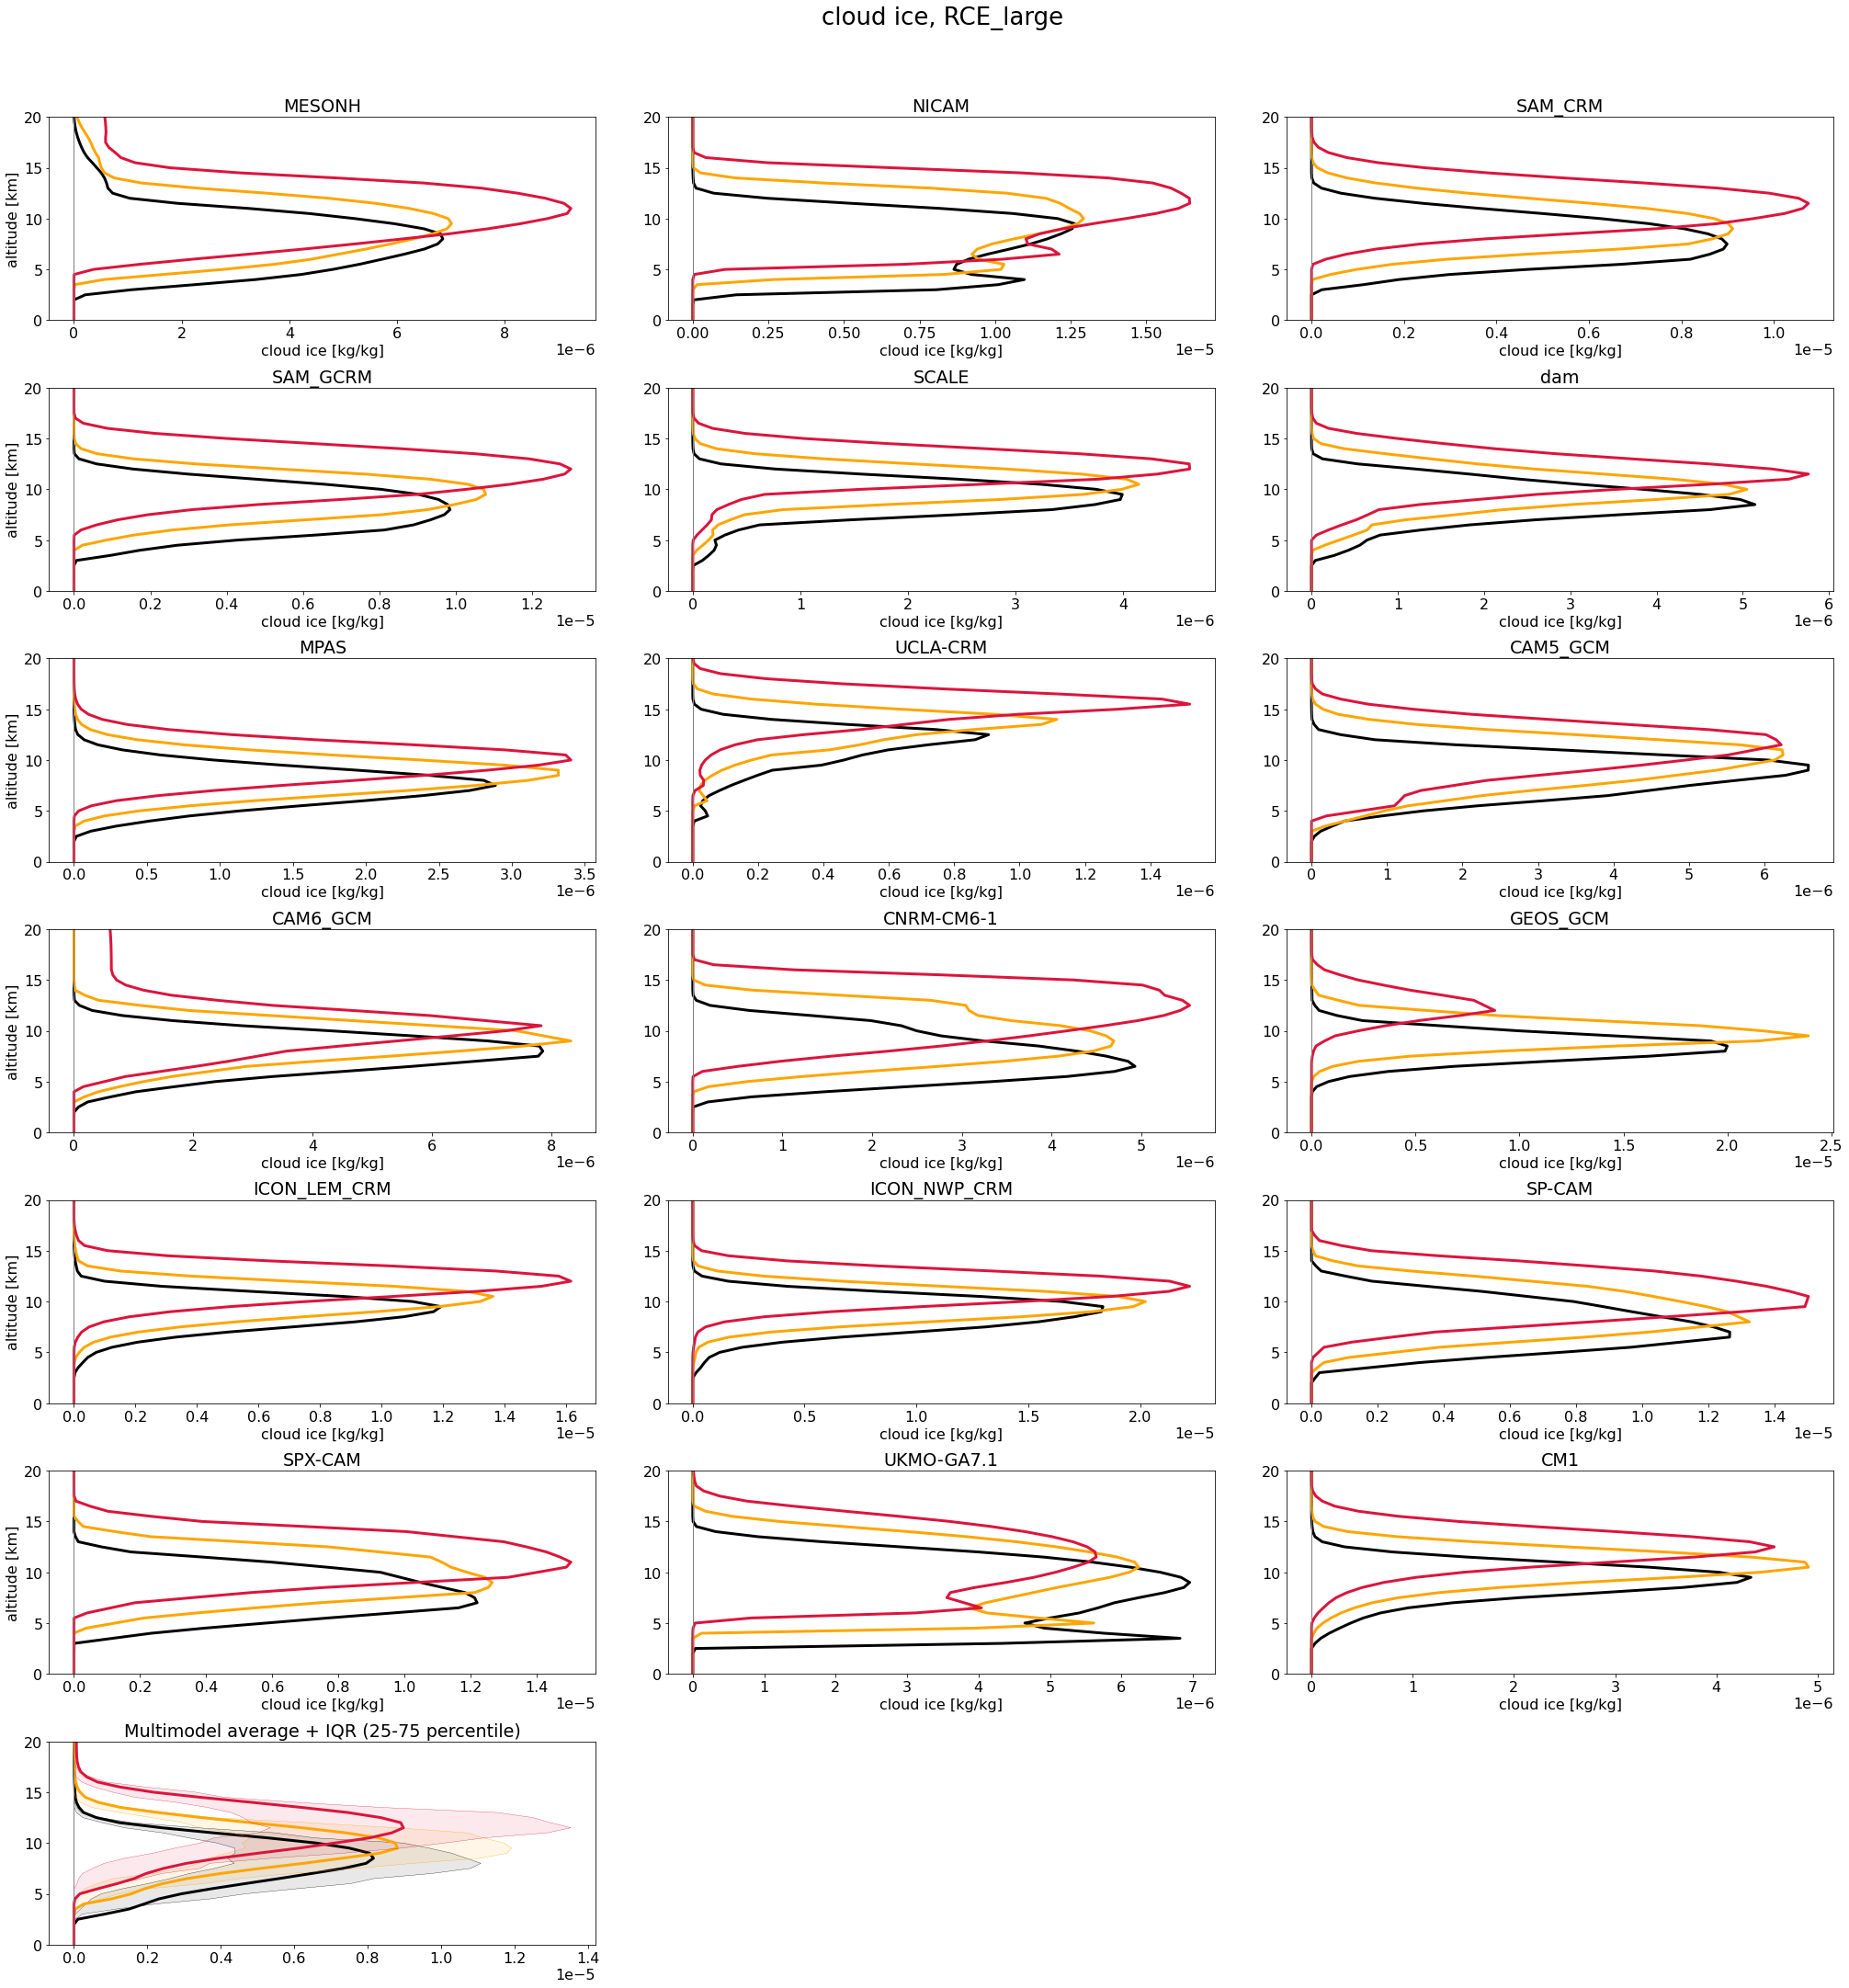

In [15]:
#cloud ice -> in units kg/kg
# to compute ice water content, need to multiply with air density!!!

fig = plt.figure()
fig.set_size_inches(36,42,forward=True)
gs = gridspec.GridSpec(15,30,height_ratios=[1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1,0.1,1],width_ratios=30*[1])


y0 = [0,0,0,2,2,2,4,4,4,6,6,6,8,8,8,10,10,10,12,12,12,14,14,14]
x0 = [0,10,20]*7


dataint={}
for m,model in enumerate(models):
    ax = fig.add_subplot(gs[y0[m],x0[m]:x0[m]+9])
    print(model,m)
    dataint[model]={}
    
    for s,sst in enumerate(ssts):
        #print(sst)
        dataint[model][sst]={}

        ds = xr.merge([xr.open_dataset(v) for v in glob.glob(path+model+'/RCE_large'+sst+'/1D/'+model+'_RCE_large'+sst+'_1D*nc')],compat='override')

        #acre 0 stuff--------------
        if (model=='ICON_LEM_CRM') | (model=='ICON_NWP_CRM'):
            acre0 = ds['cli_avg'].squeeze().values 
        elif (model=='UCLA-CRM'):
            acre0 = ds['cli_avg']#+ ds['graupel_avg'] + ds['hail_avg']+ds['snow_avg'] => falling ice not included here
        elif (model=='GEOS_GCM') | (model=='UKMO-GA7.1'):
            acre0 = ds['cli_avg']
        else:
            acre0 = ds['cli_avg']
        #acre 0 end-----------------------------
        if model=='MPAS':
            acre = ((acre0[-600:].mean(axis=1)).squeeze()).values
        else:
            if (model=='ICON_LEM_CRM') | (model=='ICON_NWP_CRM'):
                acre = ((acre0[-600:].mean(axis=0)).squeeze())              
            else:
                acre = ((acre0[-600:].mean(axis=0)).squeeze()).values
        #acre end----------------------------------
        
        if m<8: #all models with vert coordinate in meters
            zlev = ds[vertdim[m]].values/1e3 #in km
        if (m>7) & (m<12): #all models with vert coordinate as a separate file, variable in time
            zlev=((ds[vertdim[m]][-600:].mean(axis=0,skipna=True)).squeeze()).values/1e3
        if m>11: #all models with vert coordinate as a separate file, constant time
            zlev=((ds[vertdim[m]]).squeeze()).values/1e3

        if (model=='SP-CAM')|(model=='SPX-CAM'):
            acre = acre[~np.isnan(acre)]
            zlev = zlev[~np.isnan(zlev)]
          
        #here, vertical regridding: maybe on 0.5 km grid between 0 and 24 km
        acre_interp = vertinterpolate(acre,zlev,method='scipy')
        
        #now, make a dictionary
        dataint[model][sst]=acre_interp

        plt.plot(acre_interp, zlev_int,color=col[s],linewidth=3,linestyle='-',label=model+' '+sst) 
        plt.axvline(x = 0, color = 'gray',linewidth=1) 
        plt.axvline(x = 0, color = 'gray',linewidth=1)
        #plt.xlim(-0.6,2.5)
        plt.ylim(0,20)
                    
        plt.xlabel('cloud ice [kg/kg]')
        if np.mod(m,3)==0:
            plt.ylabel('altitude [km]')
        plt.title(model)
        
    if m==len(models)-1:
        ax = fig.add_subplot(gs[y0[m+1],x0[m+1]:x0[m+1]+9])
        meansst = np.zeros((len(ssts),len(zlev_int)))
        plotsst = np.zeros((len(zlev_int)))
        for s,sst in enumerate(ssts):
            cumsst=[]
            for model in dataint:
                #print(model)
                dsst = dataint[model][sst]
                cumsst.append(dsst)
            cumsst=np.array(cumsst)
            meansst[s] = np.nanmean(cumsst,axis=0)
            plotsst    = np.nanmean(cumsst,axis=0)
            plot_1quartile    = np.nanpercentile(cumsst,25,axis=0)
            plot_3quartile   = np.nanpercentile(cumsst,75,axis=0)
            plt.plot(plotsst, zlev_int,color=col[s],linewidth=3,linestyle='-')#,label='multimodel average at')
            plt.plot(plot_1quartile, zlev_int,color=col[s],linewidth=0.3,linestyle='-')
            plt.plot(plot_3quartile, zlev_int,color=col[s],linewidth=0.3,linestyle='-')
            plt.fill_betweenx(zlev_int,plot_3quartile, plot_1quartile,facecolor=col[s],alpha=0.09,
            label='25 to 75 percentile range')

            plt.axvline(x = 0, color = 'gray',linewidth=1) 
            #plt.xlim(-0.6,2.5)
            plt.ylim(0,20) 
        plt.title('Multimodel average + IQR (25-75 percentile)')

plt.suptitle('cloud ice, RCE_large',size=26,y=0.92)

#plt.savefig('/path-to-file/cloud_ice_RCE_large_analysis_nolim.pdf',dpi=200,bbox_inches='tight')


write=0
if (write == 1):
    ##############WRITE IN A NC FILE##################################################

    ############################################################################
    from netCDF4 import Dataset as NetCDFFile
    import netCDF4

    savepath = '../data/RCEMIP_processed/'

    ncfile = NetCDFFile(savepath+'RCElarge_qi_from_1D_files_z24_testprocess.nc', 'w',  format='NETCDF4_CLASSIC')

    alt = ncfile.createDimension('alt', len(zlev_int) )
    model= ncfile.createDimension('model', len(models) )
    sst = ncfile.createDimension('sst', 3 )
    nchar = ncfile.createDimension('nchar',len(models))
    nchar2 = ncfile.createDimension('nchar2',12) 
    
    #Create variables for the dimensions (so that we can have values there)
    alt= ncfile.createVariable('alt', np.float32, ('alt',))
    sst= ncfile.createVariable('sst', np.float32, ('sst',))
    
    # Create the actual 2-d variable
    cli_avg  = ncfile.createVariable('ice_mixing_ratio', np.dtype('float32').char, ('model','sst','alt'))
    
    modelnames= ncfile.createVariable('names_of_models', 'S1',('nchar','nchar2'))
    
    str_out = netCDF4.stringtochar(np.array(models,'S'))
    
    # Variable Attributes  
    cli_avg.units   = 'kg/kg'
    
    #assign values
    alt[:]       = zlev_int
    sst[:]       = ssts
    model        = models #np.enumerate(models)
    modelnames[:]=str_out
    for m,model in enumerate(models):
        for s,sst in enumerate(ssts):
            cli_avg[m,s,:] =  dataint[model][sst]


    ncfile.close()